In [15]:
#%matplotlib widget

In [1]:
from datetime import datetime, timedelta


import random
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
import ciw
import requests

def daterange(start_date_, end_date_):
    # https://stackoverflow.com/a/1060330
    for n in range(int((end_date_ - start_date_).days)):
        yield start_date_ + timedelta(n)

def special_events_between(begin, end):
    return (d.strftime("%d/%m") for d in daterange(begin, end))

def split(x, n):
    if x % n == 0:
        return [x//n for _ in range(n)]
    zp = n - (x % n)
    pp = x//n
    return [pp + 1 if i >= zp else pp for i in range(n)]

def avg_flow_per_hour(l):
    return sum(l) / 24

def simulate_queue_day(number_of_vehicles,service_distributions,number_of_servers):
    arrival_distribution = number_of_vehicles/60
    network = ciw.create_network(
        arrival_distributions=[ciw.dists.Exponential(rate=arrival_distribution)],
        service_distributions=[ciw.dists.Exponential(rate=service_distributions)],
        number_of_servers=[number_of_servers]
    )

    ciw.seed(1)

    queue = ciw.Simulation(network)
    queue.simulate_until_max_time(60)

    recs = queue.get_all_records()

    waits = [r.waiting_time for r in recs]

    mean_waiting_time = sum(waits) / len(waits)
    return mean_waiting_time



def getWeatherByday(timestamp):
    key = '5af75ce9f0c444a0af1162744220701'
    Data_Dict = {'avgtempC': 0,'pressure': 0, 'precipMM':0,'windspeedKmph':0}
    day = datetime.fromtimestamp(timestamp).date().strftime('%Y-%m-%d')
    url = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key='+key+'&q=France&format=json&date='+day
    resp = requests.get(url=url)
    data = resp.json()
    Data_Dict['avgtempC'] = data['data']['weather'][0]['avgtempC']
    Data_Dict['pressure'] = data['data']['weather'][0]['hourly'][0]['pressure']
    Data_Dict['precipMM'] = data['data']['weather'][0]['hourly'][0]['precipMM']
    Data_Dict['windspeedKmph'] = data['data']['weather'][0]['hourly'][0]['windspeedKmph']
    return Data_Dict




In [3]:
rules = {
    "avg_truck_waiting": 7,
    "avg_car_waiting": 3,
    "variations": {
        "trucks_ratio_variation_in": 0.1,
        "trucks_ratio_variation_out": 0.15,
        "avg_truck_waiting_variation": 0.4,
        "avg_car_waiting_variation": 0.25
    },
    "days": {
        "Monday": {
            "min_in": 2900,
            "max_in": 3200,
            "trucks_ratio_in": 1/10,
            "min_out": 3000,
            "max_out": 3200,
            "trucks_ratio_out": 1/9,
            "number_of_service_present_per_hour": 4
        },
        "Tuesday": {
            "min_in": 2700,
            "max_in": 3100,
            "trucks_ratio_in": 1/11,
            "min_out": 3000,
            "max_out": 3300,
            "trucks_ratio_out": 1/10,
            "number_of_service_present_per_hour": 4
        },
        "Wednesday": {
            "min_in": 3000,
            "max_in": 3100,
            "trucks_ratio_in": 1/8,
            "min_out": 2700,
            "max_out": 3100,
            "trucks_ratio_out": 1/9,
            "number_of_service_present_per_hour": 3
        },
        "Thursday": {
            "min_in": 2600,
            "max_in": 3100,
            "trucks_ratio_in": 1/12,
            "min_out": 2800,
            "max_out": 3100,
            "trucks_ratio_out": 1/7,
            "number_of_service_present_per_hour": 4
        },
        "Friday": {
            "min_in": 2900,
            "max_in": 3100,
            "trucks_ratio_in": 1/10,
            "min_out": 2800,
            "max_out": 3100,
            "trucks_ratio_out": 1/10,
            "number_of_service_present_per_hour": 4
        },
        "Saturday": {
            "min_in": 2900,
            "max_in": 3100,
            "trucks_ratio_in": 1/16,
            "min_out": 3100,
            "max_out": 3200,
            "trucks_ratio_out": 1/17,
            "number_of_service_present_per_hour": 5
        },
        "Sunday": {
            "min_in": 1600,
            "max_in": 1800,
            "trucks_ratio_in": 1/25,
            "min_out": 1700,
            "max_out": 2400,
            "trucks_ratio_out": 1/26,
            "number_of_service_present_per_hour": 5
        }
    },
    "special_events": {
        "dates": {
            
            d: f for dates, f in zip(
                [
                    special_events_between(datetime(1970, 10, 23), datetime(1970, 11, 8)), # toussaint
                    special_events_between(datetime(1970, 12, 18), datetime(1970, 1, 3)), # noel
                    special_events_between(datetime(1970, 2, 12), datetime(1970, 3, 7)), # hiver
                    special_events_between(datetime(1970, 4, 16), datetime(1970, 5, 9)), # printemps
                    special_events_between(datetime(1970, 7, 7), datetime(1970, 8, 30)) # ete
                ],
                [(2.3, 0.7), (2.5, 0.3), (2.3, 0.7), (2.1, 0.8), (2.7, 0.6)]
            ) for d in dates
        },
        "meteo": {
            "soleil": (1, 1),
            "pluie": (0.89, 1.4),
            "nuageux": (0.96, 1.1),
            "neige": (0.5, 0.6),
            "tempete": (0.2, 0.3)
        }
    }
}

In [4]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2021, 1, 1)

generated = [[
    "ts", "avg_nb_vehicules_in_per_hour", "nb_trucks_in", "nb_cars_in", "avg_waiting_in", "avg_nb_vehicules_out_per_hour", "nb_trucks_out",
    "nb_cars_out", "avg_waiting_out", "avg_temperature" ,"pressure" , "precipitaion_MM" , "windspeed_Kmph"
]]

def is_special(date):
    return date.strftime("%d/%m") in rules["special_events"]["dates"]

def get_generation_parameters(date):
    params = rules["days"][date.strftime("%A")]
    params["trucks_ratio_variation_in"] = rules["variations"]["trucks_ratio_variation_in"]
    params["trucks_ratio_variation_out"] = rules["variations"]["trucks_ratio_variation_out"]
    params["avg_truck_waiting"] = rules["avg_truck_waiting"]
    params["avg_car_waiting"] = rules["avg_car_waiting"]
    params["avg_truck_waiting_variation"] = rules["variations"]["avg_truck_waiting_variation"]
    params["avg_car_waiting_variation"] = rules["variations"]["avg_car_waiting_variation"]
    if is_special(date):
        params = deepcopy(params)
        factors = rules["special_events"]["dates"][date.strftime("%d/%m")]
        params["min_in"] = int(params["min_in"] * factors[0])
        params["max_in"] = int(params["max_in"] * factors[0])
        params["min_out"] = int(params["min_out"] * factors[0])
        params["max_out"] = int(params["max_out"] * factors[0])
        params["trucks_ratio_in"] *= factors[1]
        params["trucks_ratio_out"] *= factors[1]
        params["number_of_service_present_per_hour"] = int(params["number_of_service_present_per_hour"]*factors[0]/1.8)
    return params

def generate_for_date(date):
    gen_params = get_generation_parameters(date)
    new_gen = [date.timestamp()]
    weather_data = getWeatherByday(date.timestamp())
    temperature = int(weather_data['avgtempC'])
    pression = int(weather_data['pressure'])
    precipitation = float(weather_data['precipMM'])
    wind_speed = int(weather_data['windspeedKmph'])
    coeff =  temperature/9.5 + pression/1030 - precipitation - wind_speed/10
    # IN
    nb_vehicules_in = random.randint(gen_params["min_in"], gen_params["max_in"] + 1)
    if(coeff>0) : nb_vehicules_in += int(nb_vehicules_in*coeff)
    list_in_per_hour = split(nb_vehicules_in,24)
    avg_nb_vehicules_in_per_hour = avg_flow_per_hour(list_in_per_hour)
    new_gen.append(int(avg_nb_vehicules_in_per_hour)) # nb_vehicules_in
    trucks_ratio_in = gen_params["trucks_ratio_in"] * random.uniform(1 - gen_params["trucks_ratio_variation_in"], 1 + gen_params["trucks_ratio_variation_in"])
    nb_trucks_in = int(nb_vehicules_in * trucks_ratio_in)
    new_gen.append(nb_trucks_in) # nb_trucks_in
    nb_cars_in = nb_vehicules_in - nb_trucks_in
    new_gen.append(nb_cars_in) # nb_cars_in
    number_of_services = gen_params["number_of_service_present_per_hour"]
    avg_waiting_time_in = simulate_queue_day( avg_nb_vehicules_in_per_hour,0.1,number_of_services)

    new_gen.append(avg_waiting_time_in) # avg_waiting_in
    # OUT
    nb_vehicules_out = random.randint(gen_params["min_out"], gen_params["max_out"] + 1)
    if(coeff>0) : nb_vehicules_out += int(nb_vehicules_out*coeff)
    list_out_per_hour = split(nb_vehicules_out,24)
    avg_nb_vehicules_out_per_hour = avg_flow_per_hour(list_out_per_hour)
    new_gen.append(int(avg_nb_vehicules_out_per_hour))
    trucks_ratio_out = gen_params["trucks_ratio_out"] * random.uniform(1 - gen_params["trucks_ratio_variation_out"], 1 + gen_params["trucks_ratio_variation_out"])
    nb_trucks_out = int(nb_vehicules_out * trucks_ratio_out)
    new_gen.append(nb_trucks_out) # nb_trucks_out
    nb_cars_out = nb_vehicules_out - nb_trucks_out
    new_gen.append(nb_cars_out) # nb_cars_out
    avg_waiting_time_out = simulate_queue_day( avg_nb_vehicules_out_per_hour,0.1,number_of_services)
    new_gen.append(avg_waiting_time_out) # avg_waiting_out
    new_gen.append(temperature)
    new_gen.append(pression)
    new_gen.append(precipitation)
    new_gen.append(wind_speed)
    return new_gen

for single_date in daterange(start_date, end_date):
    generated += [generate_for_date(single_date)]

In [5]:
df = pd.DataFrame(generated[1:], columns=generated[0])
df["ts"] = pd.to_datetime(df["ts"], unit="s").dt.tz_localize('UTC').dt.tz_convert('Europe/Paris')
df = df.set_index('ts', drop=False)
df.head()

,ts,avg_nb_vehicules_in_per_hour,nb_trucks_in,nb_cars_in,avg_waiting_in,avg_nb_vehicules_out_per_hour,nb_trucks_out,nb_cars_out,avg_waiting_out,avg_temperature,pressure,precipitaion_MM,windspeed_Kmph
ts,,,,,,,,,,,,,
2020-01-01 00:00:00+01:00,2020-01-01 00:00:00+01:00,235,695,4954,16.346623,221,530,4784,22.863176,4,1032,0.0,6
2020-01-02 00:00:00+01:00,2020-01-02 00:00:00+01:00,257,517,5651,24.369710,269,817,5661,25.227702,7,1029,0.0,6
2020-01-03 00:00:00+01:00,2020-01-03 00:00:00+01:00,156,344,3413,19.996857,154,382,3316,22.787055,10,1024,0.0,18
2020-01-04 00:00:00+01:00,2020-01-04 00:00:00+01:00,176,264,3978,16.130331,187,230,4273,17.184221,7,1032,0.0,13
2020-01-05 00:00:00+01:00,2020-01-05 00:00:00+01:00,168,150,3901,19.579077,219,202,5075,18.371551,8,1037,0.0,5


In [6]:
df.to_csv("dataset_custom_sample_weather.csv", index=False)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 00:00:00+01:00 to 2020-12-31 00:00:00+01:00
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype                       
---  ------                         --------------  -----                       
 0   ts                             366 non-null    datetime64[ns, Europe/Paris]
 1   avg_nb_vehicules_in_per_hour   366 non-null    int64                       
 2   nb_trucks_in                   366 non-null    int64                       
 3   nb_cars_in                     366 non-null    int64                       
 4   avg_waiting_in                 366 non-null    float64                     
 5   avg_nb_vehicules_out_per_hour  366 non-null    int64                       
 6   nb_trucks_out                  366 non-null    int64                       
 7   nb_cars_out                    366 non-null    int64                       
 8   avg_waiting_out                

In [23]:
df.describe()

,avg_nb_vehicules_in_per_hour,nb_trucks_in,nb_cars_in,avg_waiting_in,avg_nb_vehicules_out_per_hour,nb_trucks_out,nb_cars_out,avg_waiting_out,avg_temperature,pressure,precipitaion_MM,windspeed_Kmph
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,395.710383,671.229508,8837.142077,19.580244,410.724044,758.420765,9110.240437,19.145993,14.786885,1017.005464,0.253825,12.901639
std,320.201962,474.314700,7283.268266,3.264936,329.704322,547.441995,7468.825652,3.408235,6.635599,9.492028,0.828846,6.402153
min,68.000000,61.000000,1583.000000,7.789763,79.000000,77.000000,1822.000000,6.628455,3.000000,977.000000,0.000000,2.000000
25%,179.500000,308.250000,3981.750000,17.562772,192.000000,339.750000,4301.750000,17.330482,9.000000,1012.000000,0.000000,8.000000
50%,292.500000,555.000000,6491.000000,19.918382,302.500000,615.500000,6603.000000,19.416074,14.000000,1018.000000,0.000000,12.000000
75%,446.250000,899.500000,9988.000000,21.815134,461.500000,1008.000000,10176.250000,21.197334,20.000000,1023.000000,0.100000,17.000000
max,1489.000000,2639.000000,33752.000000,27.525299,1658.000000,3162.000000,37333.000000,27.867219,33.000000,1045.000000,5.800000,42.000000


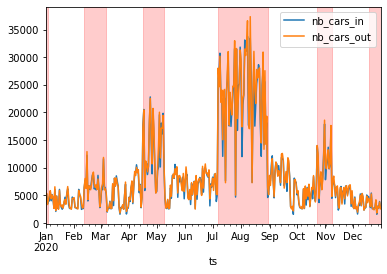

In [24]:
_, ax = plt.subplots(1, 1)
axvspan_alpha = 0.2
for year in set(df.index.year):
    ax.axvspan(datetime(year, 2, 12), datetime(year, 3, 7), color='red', alpha=axvspan_alpha), # hiver
    ax.axvspan(datetime(year, 4, 16), datetime(year, 5, 9), color='red', alpha=axvspan_alpha), # printemps
    ax.axvspan(datetime(year, 7, 7), datetime(year, 8, 30), color='red', alpha=axvspan_alpha) # ete
    ax.axvspan(datetime(year, 10, 23), datetime(year, 11, 8), color='red', alpha=axvspan_alpha) # toussaint
    ax.axvspan(datetime(year, 12, 18), datetime(year, 12, 31), color='red', alpha=axvspan_alpha), # noel
    ax.axvspan(datetime(year, 1, 1), datetime(year, 1, 3), color='red', alpha=axvspan_alpha), # noel
df[["nb_cars_in", "nb_cars_out"]].plot(ax=ax, kind="line")
plt.show()

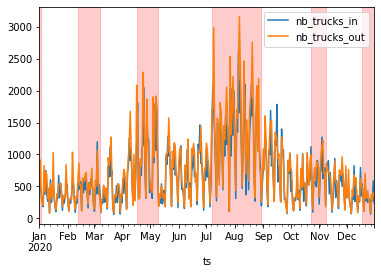

In [25]:
_, ax = plt.subplots(1, 1)
axvspan_alpha = 0.2
for year in set(df.index.year):
    ax.axvspan(datetime(year, 2, 12), datetime(year, 3, 7), color='red', alpha=axvspan_alpha), # hiver
    ax.axvspan(datetime(year, 4, 16), datetime(year, 5, 9), color='red', alpha=axvspan_alpha), # printemps
    ax.axvspan(datetime(year, 7, 7), datetime(year, 8, 30), color='red', alpha=axvspan_alpha) # ete
    ax.axvspan(datetime(year, 10, 23), datetime(year, 11, 8), color='red', alpha=axvspan_alpha) # toussaint
    ax.axvspan(datetime(year, 12, 18), datetime(year, 12, 31), color='red', alpha=axvspan_alpha), # noel
    ax.axvspan(datetime(year, 1, 1), datetime(year, 1, 3), color='red', alpha=axvspan_alpha), # noel
df[["nb_trucks_in", "nb_trucks_out"]].plot(ax=ax, kind="line")
plt.show()

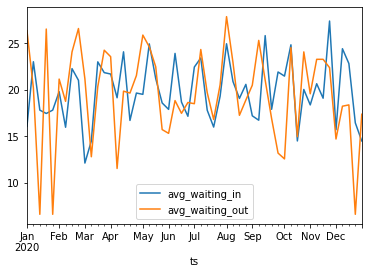

In [26]:
df[["avg_waiting_in", "avg_waiting_out"]][::7].plot(kind="line")
plt.show()

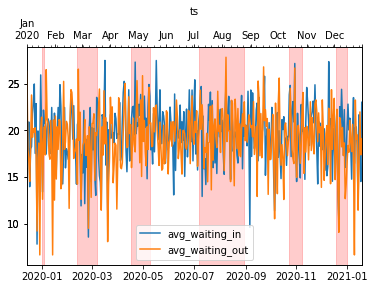

In [27]:
_, ax = plt.subplots(1, 1)
for year in set(df.index.year):
    ax.axvspan(datetime(year, 2, 12), datetime(year, 3, 7), color='red', alpha=axvspan_alpha), # hiver
    ax.axvspan(datetime(year, 4, 16), datetime(year, 5, 9), color='red', alpha=axvspan_alpha), # printemps
    ax.axvspan(datetime(year, 7, 7), datetime(year, 8, 30), color='red', alpha=axvspan_alpha) # ete
    ax.axvspan(datetime(year, 10, 23), datetime(year, 11, 8), color='red', alpha=axvspan_alpha) # toussaint
    ax.axvspan(datetime(year, 12, 18), datetime(year, 12, 31), color='red', alpha=axvspan_alpha), # noel
    ax.axvspan(datetime(year, 1, 1), datetime(year, 1, 3), color='red', alpha=axvspan_alpha), # noel
ax2 = ax.twiny()
df[["avg_waiting_in", "avg_waiting_out"]].plot(ax=ax2, kind="line")
plt.show()

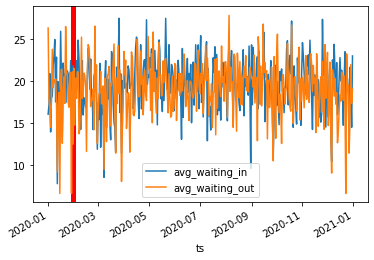

In [28]:
_, ax = plt.subplots(1, 1)
plt.axvline(x=datetime(2020, 1, 31), linewidth=5, color='red', label='brexit') # brexit
df[["avg_waiting_in", "avg_waiting_out"]].plot(ax=ax, kind="line")
plt.show()

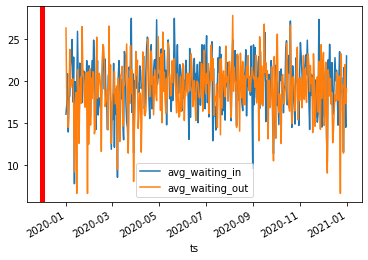

In [29]:
_, ax = plt.subplots(1, 1)
plt.axvline(x=datetime(2019, 12, 1), linewidth=5, color='red', label='brexit') # covid-19
df[["avg_waiting_in", "avg_waiting_out"]].plot(ax=ax, kind="line")
plt.show()

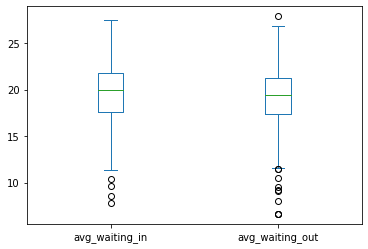

In [30]:
df[["avg_waiting_in", "avg_waiting_out"]].plot(kind="box")
plt.show()

# Statsmodel analysis (in)

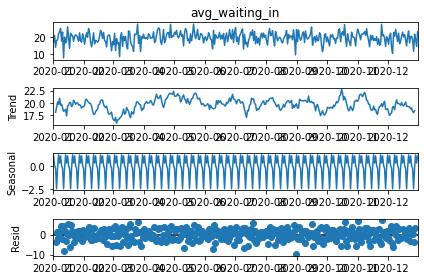

In [31]:
sm.tsa.seasonal_decompose(df["avg_waiting_in"]).plot()
plt.show()

# Statsmodel analysis (out)

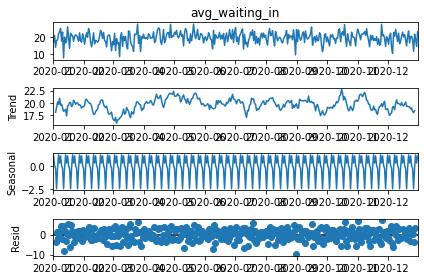

In [32]:
sm.tsa.seasonal_decompose(df["avg_waiting_in"]).plot()
plt.show()

# Prediction : sklearn LSTM : avg waiting (in)

In [ ]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df[["nb_trucks_in", "nb_cars_in", "avg_waiting_in"]])

In [ ]:
x_limit = int(0.8*(dataset.shape[0]))
y_limit = dataset.shape[0]
x_limit, y_limit, y_limit - x_limit

In [ ]:
train_x, train_y = dataset[:x_limit, :-1], dataset[:x_limit, -1]
train_x.shape, train_y.shape

In [ ]:
test_x, test_y = dataset[x_limit:y_limit, :-1], dataset[x_limit:y_limit, -1]
test_x.shape, test_y.shape

In [ ]:
"""
from sklearn.preprocessing import normalize
data = np.array([
    [1000, 10, 0.5],
    [765, 5, 0.35],
    [800, 7, 0.09], ])
data = normalize(data, axis=0, norm='max')
"""

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(1, input_shape=(1, train_x.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mae', optimizer='adam')

epochs = 20
batch_size = 7

scaler_pred = MinMaxScaler()

train_x_scaled = scaler_pred.fit_transform(train_x)

history = model_lstm.fit(train_x_scaled.reshape((train_x_scaled.shape[0], 1, train_x_scaled.shape[1])), train_y, batch_size=batch_size, epochs=epochs)
# history = model_lstm.fit(train_x.reshape((train_x.shape[0], 1, train_x.shape[1])), train_y, batch_size=batch_size, epochs=epochs)


plot_model(model_lstm, show_shapes=True)

In [ ]:
#Plot training & validation loss values
fig, ax = plt.subplots()
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Get the predicted values

test_x_scaled = scaler_pred.fit_transform(test_x)

pred_y = model_lstm.predict(test_x_scaled.reshape((test_x_scaled.shape[0], 1, test_x_scaled.shape[1])))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(test_y, pred_y)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test_y, pred_y)/ test_y))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test_y, pred_y)/ test_y)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit], pred_y.ravel(), color='orange')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-7:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit][-7:], pred_y.ravel()[-7:], color='orange')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-31:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit][-31:], pred_y.ravel()[-31:], color='orange')
plt.show()

In [ ]:
# Configure the neural network model
model_lstm_bis = Sequential()
n_neurons = train_x.shape[0] * train_x.shape[1]
model_lstm_bis.add(LSTM(n_neurons, return_sequences=True, input_shape=(1, train_x.shape[1]))) 
model_lstm_bis.add(LSTM(n_neurons, return_sequences=False))
# model.add(Dense(5))
model_lstm_bis.add(Dense(1))

# Compile the model
model_lstm_bis.compile(optimizer='adam', loss='mse')

plot_model(model_lstm_bis, show_shapes=True)

In [ ]:
epochs = 20
batch_size = 100
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

history = model_lstm_bis.fit(train_x_scaled.reshape((train_x_scaled.shape[0], 1, train_x_scaled.shape[1])), train_y, batch_size=batch_size, epochs=epochs)      

In [ ]:
#Plot training & validation loss values
_, ax = plt.subplots()
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Get the predicted values

test_x_scaled = scaler_pred.fit_transform(test_x)

pred_y = model_lstm_bis.predict(test_x_scaled.reshape((test_x_scaled.shape[0], 1, test_x_scaled.shape[1])))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(test_y, pred_y)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test_y, pred_y)/ test_y))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test_y, pred_y)/ test_y)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit], pred_y.ravel(), color='orange')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-7:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit][-7:], pred_y.ravel()[-7:], color='orange')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-31:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit][-31:], pred_y.ravel()[-31:], color='orange')
plt.show()

# Prediction : sklearn GRU : avg waiting (in)

In [ ]:
# Configure the neural network model
model_gru = Sequential()
n_neurons = train_x.shape[0] * train_x.shape[1]
model_gru.add(GRU(n_neurons, return_sequences=True, input_shape=(1, train_x.shape[1]))) 
model_gru.add(GRU(n_neurons, return_sequences=False))
# model.add(Dense(5))
model_gru.add(Dense(1))

# Compile the model
model_gru.compile(optimizer='adam', loss='mse')

plot_model(model_gru, show_shapes=True)

In [ ]:
history_gru = model_gru.fit(train_x_scaled.reshape((train_x_scaled.shape[0], 1, train_x_scaled.shape[1])), train_y, batch_size=batch_size, epochs=epochs)

In [ ]:
#Plot training & validation loss values
_, ax = plt.subplots()
plt.plot(history_gru.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Get the predicted values

test_x_scaled = scaler_pred.fit_transform(test_x)

pred_y_gru = model_gru.predict(test_x_scaled.reshape((test_x_scaled.shape[0], 1, test_x_scaled.shape[1])))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(test_y, pred_y_gru)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test_y, pred_y_gru)/ test_y))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test_y, pred_y_gru)/ test_y)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit], pred_y_gru.ravel(), color='orange')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-7:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit][-7:], pred_y_gru.ravel()[-7:], color='orange')

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-31:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[x_limit:y_limit][-31:], pred_y_gru.ravel()[-31:], color='orange')

# Prediction : FBProphet : avg waiting (in)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df[["nb_trucks_in", "nb_cars_in", "avg_waiting_in"]])

train_size_in = int(0.8*(dataset.shape[0]))

train_in = pd.DataFrame(df[["nb_trucks_in", "nb_cars_in","avg_temperature","pressure","precipitaion_MM","windspeed_Kmph","avg_waiting_in"]][:train_size_in])
train_in.reset_index(inplace=True)
train_in.rename(columns={'ts':'ds','avg_waiting_in':'y'}, inplace=True)
train_in["ds"] = train_in["ds"].dt.tz_localize(None)
test_in = pd.DataFrame(df[["nb_trucks_in", "nb_cars_in","avg_temperature","pressure","precipitaion_MM","windspeed_Kmph","avg_waiting_in"]][train_size_in:])
test_in.reset_index(inplace=True)
test_in.rename(columns={'ts':'ds','avg_waiting_in':'y'}, inplace=True)
test_in["ds"] = test_in["ds"].dt.tz_localize(None)

train_in.head()

,ds,nb_trucks_in,nb_cars_in,avg_temperature,pressure,precipitaion_MM,windspeed_Kmph,y
0,2020-01-01,695,4954,4,1032,0.0,6,16.346623
1,2020-01-02,517,5651,7,1029,0.0,6,24.369710
2,2020-01-03,344,3413,10,1024,0.0,18,19.996857
3,2020-01-04,264,3978,7,1032,0.0,13,16.130331
4,2020-01-05,150,3901,8,1037,0.0,5,19.579077


In [20]:
from fbprophet import Prophet
prophet_in = Prophet(yearly_seasonality=True)

prophet_in.add_regressor('nb_trucks_in')
prophet_in.add_regressor('nb_cars_in')
prophet_in.add_regressor('avg_temperature')
prophet_in.add_regressor('pressure')
prophet_in.add_regressor('precipitaion_MM')
prophet_in.add_regressor('windspeed_Kmph')

prophet_in.fit(train_in)
forecast_in = prophet_in.predict(test_in)
forecast_in

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.46699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.872   2.39779e-08       102.511           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       524.872   8.04302e-09       101.002      0.5833      0.5833      121   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,avg_temperature,...,windspeed_Kmph,windspeed_Kmph_lower,windspeed_Kmph_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-19,21.833107,18.684295,26.143404,21.833107,21.833107,0.529464,0.529464,0.529464,-0.149061,...,0.699884,0.699884,0.699884,1.042105,1.042105,1.042105,0.0,0.0,0.0,22.362570
1,2020-10-20,21.848143,20.319067,27.137201,21.848143,21.848143,2.000244,2.000244,2.000244,-0.036397,...,-0.137946,-0.137946,-0.137946,1.125177,1.125177,1.125177,0.0,0.0,0.0,23.848387
2,2020-10-21,21.863180,19.735603,26.735886,21.863180,21.863180,1.305985,1.305985,1.305985,0.076267,...,-0.395740,-0.395740,-0.395740,1.171710,1.171710,1.171710,0.0,0.0,0.0,23.169164
3,2020-10-22,21.878216,20.424554,27.406302,21.878216,21.878216,1.821476,1.821476,1.821476,0.076267,...,-0.137946,-0.137946,-0.137946,1.181962,1.181962,1.181962,0.0,0.0,0.0,23.699692
4,2020-10-23,21.893253,20.175576,27.176039,21.893253,21.893253,1.735829,1.735829,1.735829,0.001158,...,0.184296,0.184296,0.184296,1.157020,1.157020,1.157020,0.0,0.0,0.0,23.629082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2020-12-27,22.870627,16.830534,23.857044,22.870627,22.870627,-2.547894,-2.547894,-2.547894,-0.336835,...,-0.717983,-0.717983,-0.717983,1.545812,1.545812,1.545812,0.0,0.0,0.0,20.322733
70,2020-12-28,22.885663,20.320060,27.168663,22.885663,22.885664,0.721418,0.721418,0.721418,-0.411945,...,-0.073498,-0.073498,-0.073498,1.769125,1.769125,1.769125,0.0,0.0,0.0,23.607082
71,2020-12-29,22.900700,22.315540,29.589324,22.900700,22.900700,3.183739,3.183739,3.183739,-0.449499,...,0.055399,0.055399,0.055399,1.982234,1.982234,1.982234,0.0,0.0,0.0,26.084439
72,2020-12-30,22.915736,21.886311,28.806007,22.915736,22.915737,2.393594,2.393594,2.393594,-0.449499,...,0.313193,0.313193,0.313193,2.182021,2.182021,2.182021,0.0,0.0,0.0,25.309331


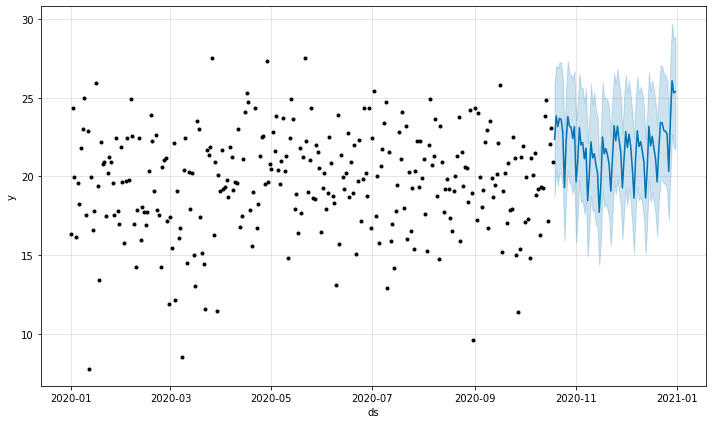

In [9]:
prophet_in.plot(forecast_in)
plt.show()

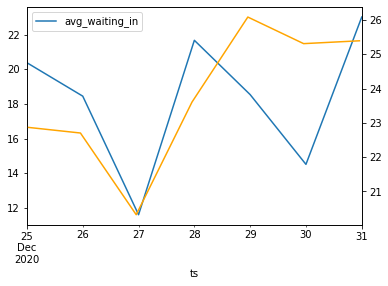

In [10]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-7:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-7:], forecast_in["yhat"][-7:], color='orange')
plt.show()

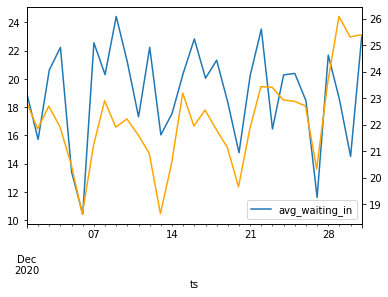

In [11]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-31:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-31:], forecast_in["yhat"][-31:], color='orange')
plt.show()

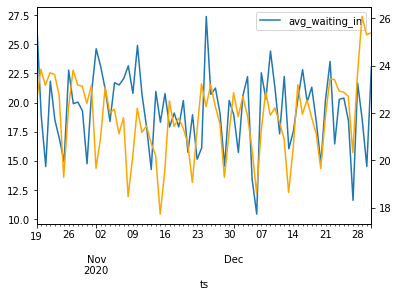

In [12]:
nb_predicted = forecast_in['yhat'].shape[0]
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-nb_predicted:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-nb_predicted:], forecast_in["yhat"][-nb_predicted:], color='orange')
plt.show()

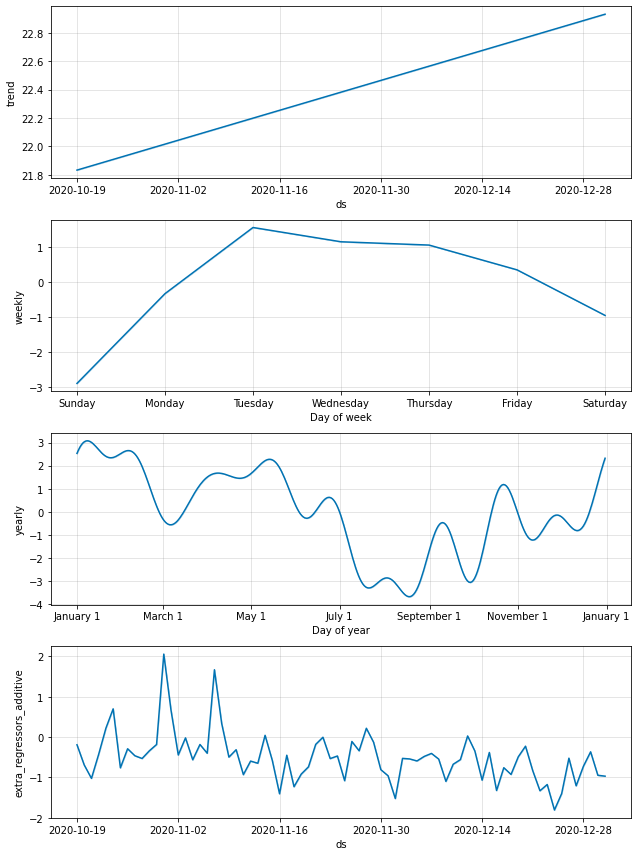

In [13]:
prophet_in.plot_components(forecast_in)
plt.show()

# Prediction : FBProphet : avg waiting (out)

In [21]:
train_size_out = int(0.8*(dataset.shape[0]))

train_out = pd.DataFrame(df[["nb_trucks_out", "nb_cars_out","avg_temperature","pressure","precipitaion_MM","windspeed_Kmph","avg_waiting_out"]][:train_size_out])
train_out.reset_index(inplace=True)
train_out.rename(columns={'ts':'ds','avg_waiting_out':'y'}, inplace=True)
train_out["ds"] = train_out["ds"].dt.tz_localize(None)
test_out = pd.DataFrame(df[["nb_trucks_out", "nb_cars_out","avg_temperature","pressure","precipitaion_MM","windspeed_Kmph", "avg_waiting_out"]][train_size_out:])
test_out.reset_index(inplace=True)
test_out.rename(columns={'ts':'ds','avg_waiting_out':'y'}, inplace=True)
test_out["ds"] = test_out["ds"].dt.tz_localize(None)

train_out.head()

,ds,nb_trucks_out,nb_cars_out,avg_temperature,pressure,precipitaion_MM,windspeed_Kmph,y
0,2020-01-01,530,4784,4,1032,0.0,6,22.863176
1,2020-01-02,817,5661,7,1029,0.0,6,25.227702
2,2020-01-03,382,3316,10,1024,0.0,18,22.787055
3,2020-01-04,230,4273,7,1032,0.0,13,17.184221
4,2020-01-05,202,5075,8,1037,0.0,5,18.371551


In [22]:
prophet_out = Prophet(yearly_seasonality=True)

prophet_out.add_regressor('nb_trucks_out')
prophet_out.add_regressor('nb_cars_out')
prophet_out.add_regressor('avg_temperature')
prophet_out.add_regressor('pressure')
prophet_out.add_regressor('precipitaion_MM')
prophet_out.add_regressor('windspeed_Kmph')

prophet_out.fit(train_out)
forecast_out = prophet_out.predict(test_out)
forecast_out

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.06032
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        505.31   1.27462e-08       101.629      0.5236      0.5236      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        505.31   8.29367e-09       102.195      0.1602      0.4669      125   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,avg_temperature,...,windspeed_Kmph,windspeed_Kmph_lower,windspeed_Kmph_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-19,16.453087,16.235195,23.852314,16.453087,16.453087,3.674316,3.674316,3.674316,0.215208,...,0.797229,0.797229,0.797229,2.754201,2.754201,2.754201,0.0,0.0,0.0,20.127403
1,2020-10-20,16.433036,14.987676,22.207115,16.433036,16.433036,2.066887,2.066887,2.066887,0.052549,...,-0.157133,-0.157133,-0.157133,2.627072,2.627072,2.627072,0.0,0.0,0.0,18.499923
2,2020-10-21,16.412985,15.257514,22.604956,16.412985,16.412985,2.266779,2.266779,2.266779,-0.110111,...,-0.450783,-0.450783,-0.450783,2.467033,2.467033,2.467033,0.0,0.0,0.0,18.679765
3,2020-10-22,16.392935,15.661897,23.209386,16.392935,16.392935,2.918372,2.918372,2.918372,-0.110111,...,-0.157133,-0.157133,-0.157133,2.275803,2.275803,2.275803,0.0,0.0,0.0,19.311307
4,2020-10-23,16.372884,16.317924,23.848640,16.372884,16.372884,3.876522,3.876522,3.876522,-0.001671,...,0.209929,0.209929,0.209929,2.055897,2.055897,2.055897,0.0,0.0,0.0,20.249406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2020-12-27,15.069590,7.467938,15.232232,15.069589,15.069590,-3.678744,-3.678744,-3.678744,0.486308,...,-0.817845,-0.817845,-0.817845,-0.181909,-0.181909,-0.181909,0.0,0.0,0.0,11.390845
70,2020-12-28,15.049539,12.237196,19.684225,15.049538,15.049539,1.013710,1.013710,1.013710,0.594747,...,-0.083720,-0.083720,-0.083720,-0.339921,-0.339921,-0.339921,0.0,0.0,0.0,16.063249
71,2020-12-29,15.029488,11.816587,19.272678,15.029488,15.029489,0.581799,0.581799,0.581799,0.648967,...,0.063105,0.063105,0.063105,-0.513136,-0.513136,-0.513136,0.0,0.0,0.0,15.611287
72,2020-12-30,15.009437,12.377571,19.831360,15.009437,15.009438,1.031288,1.031288,1.031288,0.648967,...,0.356754,0.356754,0.356754,-0.701811,-0.701811,-0.701811,0.0,0.0,0.0,16.040726


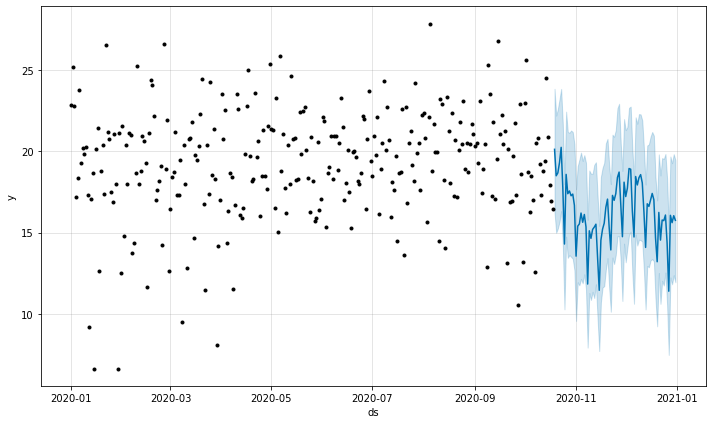

In [23]:
prophet_out.plot(forecast_out)
plt.show()

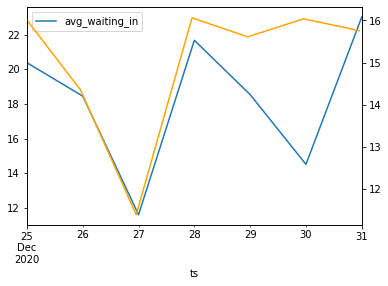

In [24]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-7:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-7:], forecast_out["yhat"][-7:], color='orange')
plt.show()

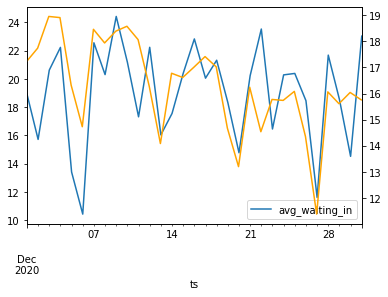

In [25]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-31:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-31:], forecast_out["yhat"][-31:], color='orange')
plt.show()

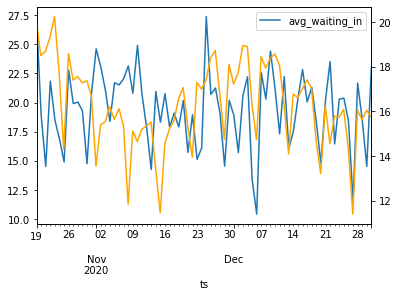

In [26]:
nb_predicted = forecast_out['yhat'].shape[0]
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-nb_predicted:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-nb_predicted:], forecast_out["yhat"][-nb_predicted:], color='orange')
plt.show()

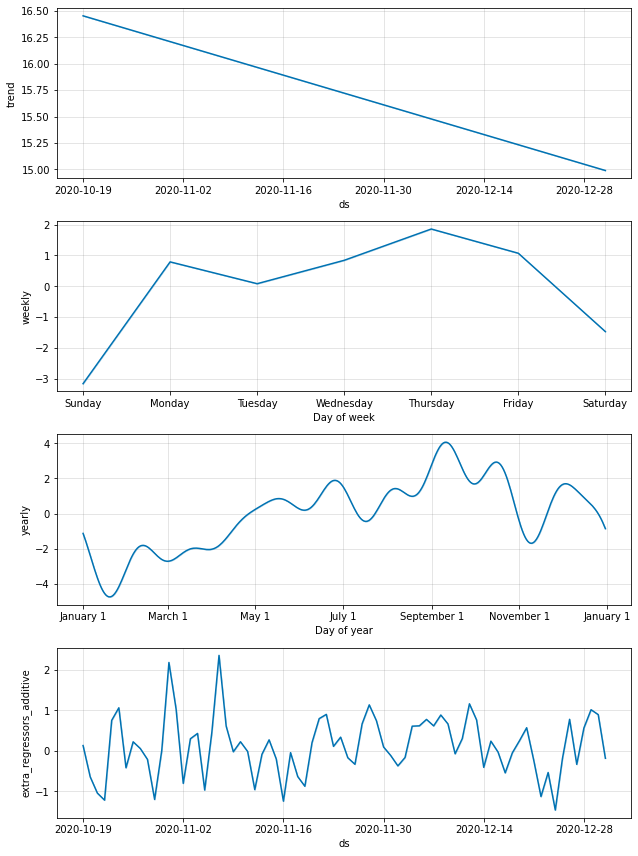

In [27]:
prophet_out.plot_components(forecast_out)
plt.show()

# Using Optuna for Hyperparameters tuning
https://medium.com/databulls/e-commerce-forecasting-fbprophet-optuna-6e9a83d89079

In [ ]:
from fbprophet import Prophet
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.__version__

## Prediction : FBProphet x Optuna : avg waiting (in)

In [ ]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        # 'growth': trial.suggest_categorical('growth', ['linear', 'logistic']), => ValueError: Capacities must be supplied for logistic growth in column "cap"
        'growth': trial.suggest_categorical('growth', ['linear']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }

    m = Prophet(**params)
    m.add_country_holidays(country_name='FR')
    m.fit(train_in)
    predictions = m.predict(test_in)

    mae_score = mean_absolute_error(test_in['y'], predictions['yhat'])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
study.best_params

In [ ]:
def regression_report(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)

    report_dict = {
        'mae_score': mae_score,
        'mse_score': mse_score,
        'r2_score': R2_score
    }

    return report_dict
prophet_in_tuned = Prophet(**study.best_params)
prophet_in_tuned.add_country_holidays(country_name='FR')

prophet_in_tuned.fit(train_in)
forecast_in_tuned = prophet_in_tuned.predict(test_in)

In [ ]:
nb_predicted = forecast_in_tuned['yhat'].shape[0]
result_prophet_in_tuned = regression_report(test_in['y'][-nb_predicted:], forecast_in_tuned['yhat'])
result_prophet_in_tuned

In [ ]:
prophet_in_tuned.plot(forecast_in_tuned)
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-7:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(forecast_in_tuned["ds"][-7:], forecast_in_tuned["yhat"][-7:], color='orange')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-31:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(forecast_in_tuned["ds"][-31:], forecast_in_tuned["yhat"][-31:], color='orange')
plt.show()

In [ ]:
nb_predicted = forecast_in_tuned['yhat'].shape[0]
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-nb_predicted:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(forecast_in_tuned["ds"][-nb_predicted:], forecast_in_tuned["yhat"][-nb_predicted:], color='orange')
plt.show()

# Prediction : FBProphet x Optuna : avg waiting (out)

In [ ]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        # 'growth': trial.suggest_categorical('growth', ['linear', 'logistic']), => ValueError: Capacities must be supplied for logistic growth in column "cap"
        'growth': trial.suggest_categorical('growth', ['linear']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }

    m = Prophet(**params)
    m.add_country_holidays(country_name='FR')
    m.fit(train_out)
    predictions = m.predict(test_out)

    mae_score = mean_absolute_error(test_out['y'], predictions['yhat'])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
study.best_params

In [ ]:
def regression_report(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)

    report_dict = {
        'mae_score': mae_score,
        'mse_score': mse_score,
        'r2_score': R2_score
    }

    return report_dict
prophet_out_tuned = Prophet(**study.best_params)
prophet_out_tuned.add_country_holidays(country_name='FR')

prophet_out_tuned.fit(train_out)
forecast_out_tuned = prophet_out_tuned.predict(test_out)

In [ ]:
nb_predicted = forecast_out_tuned['yhat'].shape[0]
result_prophet_out_tuned = regression_report(test_out['y'][-nb_predicted:], forecast_out_tuned['yhat'])
result_prophet_out_tuned

In [ ]:
prophet_out_tuned.plot(forecast_out_tuned)
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-7:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-7:], forecast_out_tuned["yhat"][-7:], color='orange')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-31:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-31:], forecast_out_tuned["yhat"][-31:], color='orange')
plt.show()

In [ ]:
nb_predicted = forecast_out_tuned['yhat'].shape[0]
_, ax = plt.subplots(1, 1)
df[["avg_waiting_in"]][-nb_predicted:].plot(ax=ax, kind="line")
ax2 = ax.twinx()
ax2.plot(df.index[-nb_predicted:], forecast_out_tuned["yhat"][-nb_predicted:], color='orange')
plt.show()

# Prediction : Statsmodel::VAR : avg waiting (in) [NOT WORKING]

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
var_model = VAR(train_in[["nb_trucks_in", "nb_cars_in"]])
var_model

In [ ]:
var_model_fit = var_model.fit()
var_model_fit

In [ ]:
var_forecast_in = var_model_fit.forecast(train_in["y"], steps=1)
var_forecast_in

In [ ]:
var_forecast_in.plot()